In [1]:
import numpy as np

import os

from statsmodels.stats.api import DescrStatsW
from scipy.stats import ttest_rel, sem

import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
def labels_to_counts(labels, time_axis=0):
    onehot = np.zeros((labels.size, n_classes), dtype=int)
    onehot[np.arange(labels.size), labels] = 1
    
    return onehot.cumsum(axis=time_axis)


def log_utility(counts):
    return np.log(counts[:, 1:] + 1).sum(axis=1)


def linear_utility(counts):
    return counts[:, 1:].sum(axis=1)


# data = 'square'
# n_classes = 6  # 6
# budget = 100
# n_exps = 20

data = 'citeseer'
n_classes = 10
budget = 500
n_exps = 20

# data = 'fatemah_100'
# n_classes = 30
# budget = 100
# n_exps = 20

# data = 'bmg'
# n_classes = 2
# budget = 500
# n_exps = 20

policies = [
    'ens jensen greedy_500',
    'classical ens_500',
    'greedy',
    'round robin greedy',
    'round robin ens_500',
    # 'round robin ucb_0.1',
    # 'round robin ucb_0.3',
    # 'round robin ucb_1.0',
    # 'round robin ucb_3.0',
    # 'round robin ucb_10.0',
    # 'malkomes_0.25',
    # 'malkomes_0.5',
    # 'malkomes_0.75',
]
if n_classes == 2 and 'round robin greedy' in policies:
    policies.remove('round robin greedy')
    
ucb_beta = 3
utility_function = linear_utility

init_size = 1
group_size = n_classes - 1

basepath = os.path.join('../../data/results', data, str(group_size))
# basepath = os.path.join('../../data/results/results_ucb_main', data, str(group_size))
# basepath = os.path.join('../../data/results/results_malkomes', data, str(group_size))

utilities = np.ones((len(policies), n_exps, budget + init_size)) * -1

for p_ind, policy in enumerate(policies):
    folder = policy
    if policy.endswith('ucb'):
        folder += f' {ucb_beta}'
    
    for i in range(n_exps):
        labels = np.loadtxt(
            os.path.join(basepath, folder, f'{policy}__labels__{i + 1}.csv'), 
            dtype=int
        ).flatten() - 1

        utilities[p_ind, i, :] = utility_function(labels_to_counts(labels))
        
assert np.all(utilities != -1)

In [5]:
utilities[..., -1].mean(axis=1)

array([433.55, 459.25, 426.1 , 385.8 , 431.05])

ens jensen greedy_500: 433.55
classical ens_500: 459.25
greedy: 426.10
round robin greedy: 385.80
round robin ens_500: 431.05


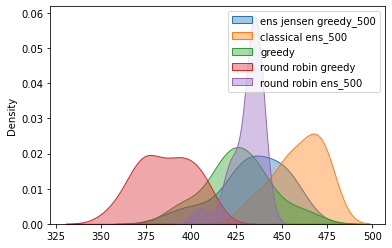

In [7]:
for p_ind, policy in enumerate(policies):
    print(f'{policy}: {utilities[p_ind, :, -1].mean():.2f}')
    sns.kdeplot(utilities[p_ind, :, -1], alpha=0.4, shade=True, label=policy)
    
plt.legend();

ens jensen greedy_500: 433.55
classical ens_500: 459.25
greedy: 426.10
round robin greedy: 385.80
round robin ens_500: 431.05


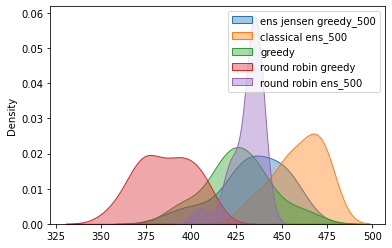

In [8]:
for p_ind, policy in enumerate(policies):
    print(f'{policy}: {utilities[p_ind, :, -1].mean():.2f}')
    sns.kdeplot(utilities[p_ind, :, -1], alpha=0.4, shade=True, label=policy)
    
plt.legend();

In [9]:
for p1 in range(len(policies) - 1):
    for p2 in range(p1 + 1, len(policies)):
        if utilities[p1, :, -1].mean() < utilities[p2, :, -1].mean():
            alternative = "less"
        else:
            alternative = "greater"
        
        print(policies[p1], "vs.", policies[p2])
        print(
            ttest_rel(
                utilities[p1, :, -1], 
                utilities[p2, :, -1],
                # alternative=alternative
            ).pvalue
        )
    
    print()

ens jensen greedy_500 vs. classical ens_500
6.9736503638323e-06
ens jensen greedy_500 vs. greedy
0.17179406181438267
ens jensen greedy_500 vs. round robin greedy
6.843643623191683e-08
ens jensen greedy_500 vs. round robin ens_500
0.6304522359017002

classical ens_500 vs. greedy
4.25629314293533e-07
classical ens_500 vs. round robin greedy
7.976283732702844e-13
classical ens_500 vs. round robin ens_500
6.339560079313709e-07

greedy vs. round robin greedy
4.4674883186900236e-08
greedy vs. round robin ens_500
0.2219448033896924

round robin greedy vs. round robin ens_500
7.201120859651938e-10



13.307475483821225 14.401680284036956
0.27
4.619807529487861 5.469856209174374
0.21
8.414292057156775 8.929271014598633
0.13
11.09612384202353 12.295449821133236
0.30
12.319690731010525 12.760573578635181
0.11


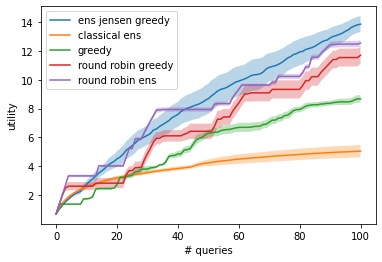

In [8]:
plt.figure()

for p_ind, policy in enumerate(policies):
    plt.plot(utilities[p_ind].mean(axis=0), label=policy)
    lower, upper = DescrStatsW(utilities[p_ind]).tconfint_mean()
    plt.fill_between(np.arange(init_size + budget), lower, upper, alpha=0.3)
    
    print(lower[-1], upper[-1])
    print(f'{(upper[-1] - lower[-1]) / 4:.2f}')
    
plt.xlabel("# queries")
plt.ylabel("utility")
plt.legend();